In [1]:
import cv2
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint

In [2]:
device = "gpu" # please change it to "gpu" if the model needs to be run on cuda.

In [3]:
protoFile = "pose_deploy_linevec.prototxt"
weightsFile = "pose_iter_440000.caffemodel"

In [4]:
image1 = cv2.imread('multiplePeople1.JPG')

In [5]:
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

In [6]:
#protoFile = "pose/coco/pose_deploy_linevec.prototxt"
#weightsFile = "pose/coco/pose_iter_440000.caffemodel"


nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho',
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip',
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44],
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30],
          [47,48], [49,50], [53,54], [51,52], [55,56],
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

In [7]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):

    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []

    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

In [8]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid

        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ])
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)

                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs

In [9]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])):
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [10]:
t = time.time()


net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Using GPU device
Time Taken = 3.25028657913208


(-0.5, 1422.5, 793.5, -0.5)

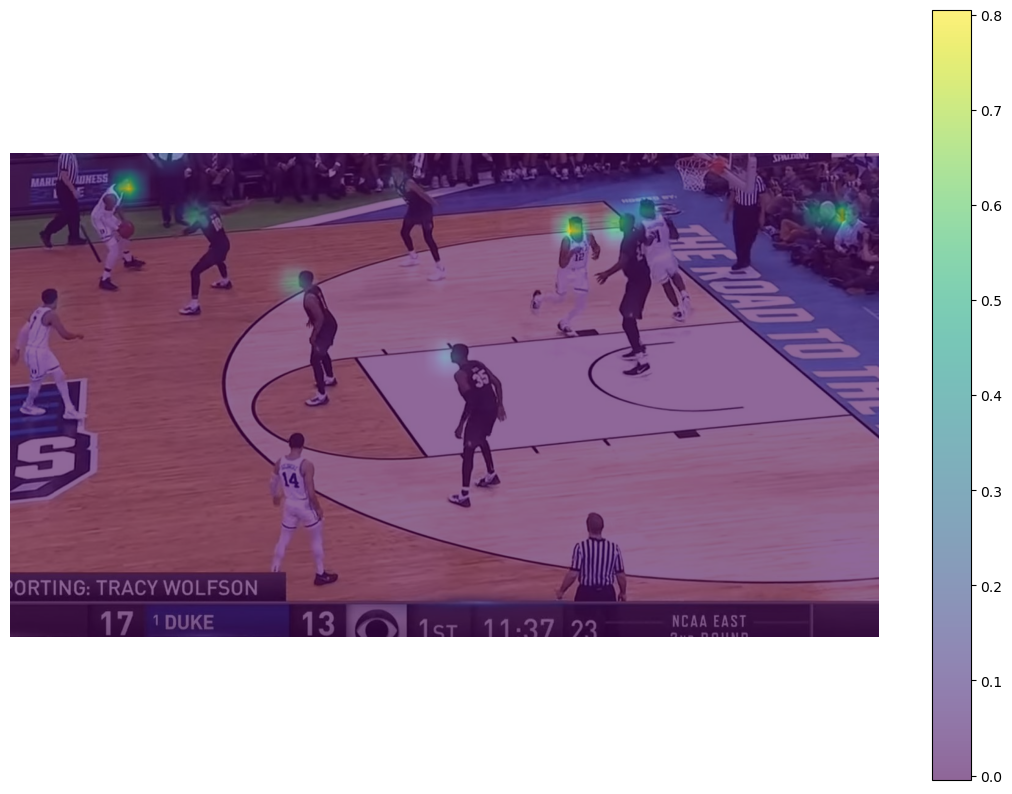

In [11]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [12]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)

Keypoints - Nose : [(712, 336, 0.2331274), (471, 215, 0.3684355), (316, 111, 0.29531682), (1362, 111, 0.7046575), (917, 129, 0.80448115), (642, 59, 0.119248316), (196, 60, 0.79846346), (264, 0, 0.20818336)]
Keypoints - Neck : [(951, 647, 0.9187839), (470, 508, 0.8410566), (745, 353, 0.9206497), (59, 266, 0.76912934), (488, 232, 0.8744257), (917, 146, 0.9184803), (1363, 113, 0.78536075), (1037, 112, 0.8563575), (317, 112, 0.5311767), (164, 61, 0.6698777), (643, 60, 0.6380033), (1207, 44, 0.5669861), (264, 0, 0.50338453), (94, 0, 0.6540332)]
Keypoints - R-Sho : [(985, 647, 0.8350176), (488, 509, 0.91533524), (763, 353, 0.78280723), (60, 266, 0.8480752), (505, 232, 0.7530627), (900, 146, 0.9242738), (1021, 113, 0.7028198), (1346, 113, 0.77563596), (317, 111, 0.4953804), (163, 61, 0.772017), (643, 60, 0.6051983), (1208, 44, 0.50051284), (248, 0, 0.5457592), (94, 0, 0.6986539)]
Keypoints - R-Elb : [(986, 682, 0.76424944), (488, 560, 0.85545415), (796, 372, 0.7408708), (522, 266, 0.10264764)

In [13]:
nPoints

18

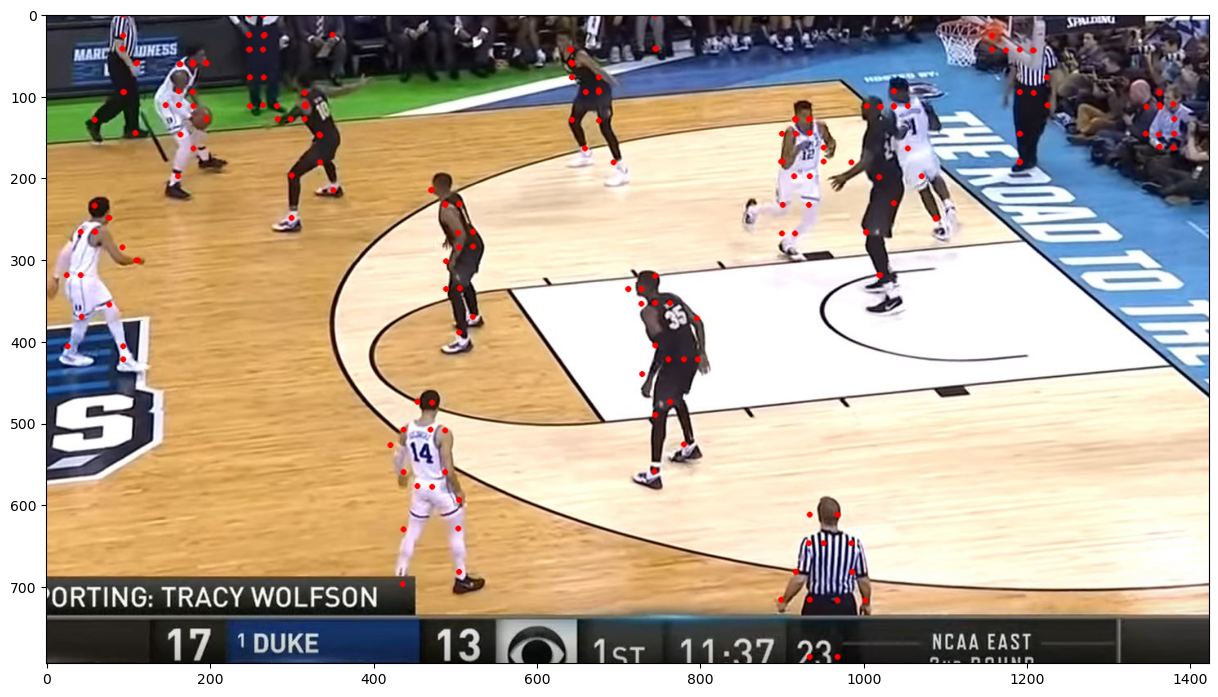

In [14]:
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [15]:
valid_pairs, invalid_pairs = getValidPairs(output)

[array([[ 8.        , 22.        ,  0.99152189],
       [ 9.        , 23.        ,  0.95302097],
       [10.        , 24.        ,  0.87747665],
       [11.        , 25.        ,  0.89263171],
       [12.        , 26.        ,  0.74260013],
       [13.        , 27.        ,  0.99020163],
       [14.        , 29.        ,  0.68770448],
       [15.        , 28.        ,  0.67350525],
       [17.        , 31.        ,  0.19904973],
       [19.        , 33.        ,  0.42507122],
       [20.        , 34.        ,  0.54688256]]), array([[ 8.        , 62.        ,  0.98432376],
       [ 9.        , 63.        ,  0.92898629],
       [10.        , 64.        ,  0.71853785],
       [11.        , 65.        ,  0.87241814],
       [12.        , 66.        ,  0.46997873],
       [13.        , 67.        ,  0.98224575],
       [14.        , 68.        ,  0.66649609],
       [15.        , 70.        ,  0.79686229],
       [17.        , 71.        ,  0.31718445],
       [18.        , 72.        ,  0.

In [16]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

In [17]:
personwiseKeypoints.shape

(29, 19)

In [18]:
personwiseKeypoints

array([[ -1.        ,   8.        ,  22.        ,  36.        ,
         50.        ,  62.        ,  76.        ,  88.        ,
        103.        , 116.        ,  -1.        , 145.        ,
        158.        ,  -1.        ,  -1.        ,  -1.        ,
        202.        , 211.        ,  18.71744226],
       [ -1.        ,   9.        ,  23.        ,  37.        ,
         51.        ,  63.        ,  77.        ,  89.        ,
        104.        , 117.        , 131.        , 146.        ,
        159.        , 173.        ,  -1.        ,  -1.        ,
        203.        , 212.        ,  21.84893731],
       [  0.        ,  10.        ,  24.        ,  38.        ,
         52.        ,  64.        ,  78.        ,  90.        ,
        105.        , 118.        , 132.        , 147.        ,
        160.        , 174.        ,  -1.        ,  -1.        ,
        204.        , 213.        ,  21.20146608],
       [ -1.        ,  11.        ,  25.        ,  40.        ,
         53.   

In [19]:
len(personwiseKeypoints)

29

In [20]:
keypoints_list

array([[7.12000000e+02, 3.36000000e+02, 2.33127400e-01],
       [4.71000000e+02, 2.15000000e+02, 3.68435502e-01],
       [3.16000000e+02, 1.11000000e+02, 2.95316815e-01],
       [1.36200000e+03, 1.11000000e+02, 7.04657495e-01],
       [9.17000000e+02, 1.29000000e+02, 8.04481149e-01],
       [6.42000000e+02, 5.90000000e+01, 1.19248316e-01],
       [1.96000000e+02, 6.00000000e+01, 7.98463464e-01],
       [2.64000000e+02, 0.00000000e+00, 2.08183363e-01],
       [9.51000000e+02, 6.47000000e+02, 9.18783903e-01],
       [4.70000000e+02, 5.08000000e+02, 8.41056585e-01],
       [7.45000000e+02, 3.53000000e+02, 9.20649707e-01],
       [5.90000000e+01, 2.66000000e+02, 7.69129336e-01],
       [4.88000000e+02, 2.32000000e+02, 8.74425709e-01],
       [9.17000000e+02, 1.46000000e+02, 9.18480277e-01],
       [1.36300000e+03, 1.13000000e+02, 7.85360754e-01],
       [1.03700000e+03, 1.12000000e+02, 8.56357515e-01],
       [3.17000000e+02, 1.12000000e+02, 5.31176686e-01],
       [1.64000000e+02, 6.10000

In [21]:
person_coordinates = []

for person in personwiseKeypoints:
    coordinates_sum = np.zeros(2)
    num_keypoints = 0
    
    for i in range(18):
        if person[i] != -1:
            coordinates_sum += keypoints_list[int(person[i]), :2]
            num_keypoints += 1
    
    if num_keypoints > 0:
        average_coordinates = coordinates_sum / num_keypoints
        person_coordinates.append(average_coordinates)

print("Person Coordinates:")
for i, coordinates in enumerate(person_coordinates):
    print("Person {}: ({}, {})".format(i+1, coordinates[0], coordinates[1]))

Person Coordinates:
Person 1: (952.2307692307693, 689.7692307692307)
Person 2: (465.3333333333333, 567.2)
Person 3: (753.8125, 411.5)
Person 4: (61.0, 317.4166666666667)
Person 5: (501.2307692307692, 288.15384615384613)
Person 6: (920.5, 176.61111111111111)
Person 7: (1366.1538461538462, 130.23076923076923)
Person 8: (1022.9090909090909, 195.0909090909091)
Person 9: (173.73333333333332, 101.4)
Person 10: (1190.909090909091, 95.0)
Person 11: (257.0, 46.333333333333336)
Person 12: (662.6363636363636, 103.9090909090909)
Person 13: (299.3333333333333, 117.0)
Person 14: (643.0, 68.5)
Person 15: (99.0, 34.0)
Person 16: (317.0, 120.0)
Person 17: (94.0, 13.0)
Person 18: (322.6666666666667, 161.77777777777777)
Person 19: (120.0, 55.5)
Person 20: (1028.0, 275.0)
Person 21: (102.0, 120.0)
Person 22: (745.0, 21.0)
Person 23: (1080.0, 223.5)
Person 24: (76.5, 112.0)
Person 25: (745.5, 21.0)
Person 26: (76.5, 249.0)
Person 27: (264.5, 0.0)
Person 28: (720.0, 336.0)
Person 29: (641.5, 43.0)


In [23]:
# Store the keypoints for each person in the persons_keypoints list
person_keypoints = []
for person in personwiseKeypoints:
    keypoints_dict = {}
    for i in range(nPoints):
        if person[i] != -1:
            body_part_name = keypointsMapping[i]
            body_part_coordinates = (int(keypoints_list[int(person[i]), 0]), int(keypoints_list[int(person[i]), 1]))
            keypoints_dict[i] = body_part_coordinates
        else:
            keypoints_dict[i] = None
    person_keypoints.append(keypoints_dict)

person_keypoints.append(person_keypoints)

In [24]:
person_keypoints

[{0: None,
  1: (951, 647),
  2: (985, 647),
  3: (986, 682),
  4: (1002, 717),
  5: (933, 647),
  6: (917, 682),
  7: (899, 716),
  8: (968, 717),
  9: (968, 786),
  10: None,
  11: (934, 716),
  12: (934, 786),
  13: None,
  14: None,
  15: None,
  16: (968, 612),
  17: (934, 612)},
 {0: None,
  1: (470, 508),
  2: (488, 509),
  3: (488, 560),
  4: (505, 594),
  5: (437, 508),
  6: (421, 527),
  7: (437, 560),
  8: (472, 578),
  9: (504, 629),
  10: (505, 682),
  11: (454, 577),
  12: (437, 630),
  13: (436, 697),
  14: None,
  15: None,
  16: (472, 475),
  17: (454, 474)},
 {0: (712, 336),
  1: (745, 353),
  2: (763, 353),
  3: (796, 372),
  4: (797, 422),
  5: (728, 354),
  6: (745, 405),
  7: (729, 440),
  8: (780, 422),
  9: (763, 474),
  10: (780, 526),
  11: (761, 422),
  12: (745, 490),
  13: (744, 559),
  14: None,
  15: None,
  16: (745, 320),
  17: (728, 336)},
 {0: None,
  1: (59, 266),
  2: (60, 266),
  3: (93, 285),
  4: (112, 301),
  5: (42, 266),
  6: None,
  7: None,


In [25]:
person_keypoints[0][1]

(951, 647)

In [27]:
df = pd.DataFrame(person_keypoints[0])
df.columns = keypointsMapping

In [28]:
df

Nose  Neck  R-Sho  R-Elb  R-Wr  L-Sho  L-Elb  L-Wr  R-Hip  R-Knee R-Ank  \
0  None   951    985    986  1002    933    917   899    968     968  None   
1  None   647    647    682   717    647    682   716    717     786  None   

   L-Hip  L-Knee L-Ank R-Eye L-Eye  R-Ear  L-Ear  
0    934     934  None  None  None    968    934  
1    716     786  None  None  None    612    612

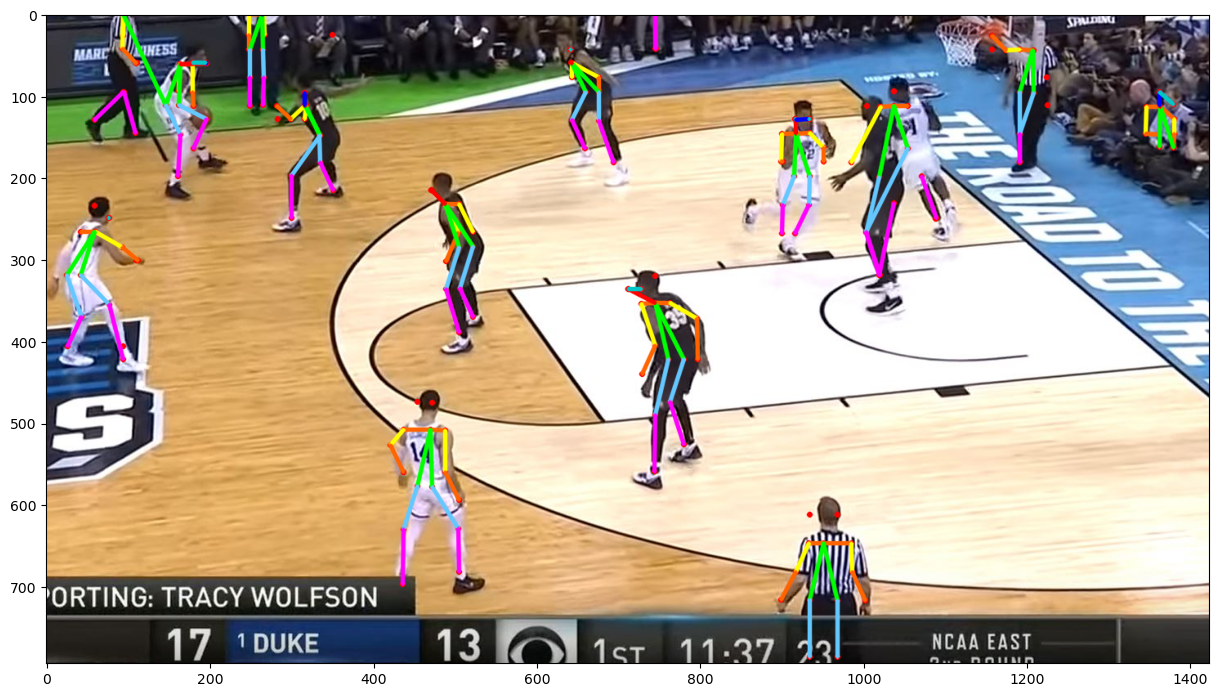

In [29]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)

plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [30]:
personwiseKeypoints.shape

(29, 19)

In [31]:
personwiseKeypoints[0]

array([ -1.        ,   8.        ,  22.        ,  36.        ,
        50.        ,  62.        ,  76.        ,  88.        ,
       103.        , 116.        ,  -1.        , 145.        ,
       158.        ,  -1.        ,  -1.        ,  -1.        ,
       202.        , 211.        ,  18.71744226])

In [32]:
person_coordinates = []

for person in personwiseKeypoints:
    coordinates_sum = np.zeros(2)
    num_keypoints = 0

    for i in range(18):
        if person[i] != -1:
            coordinates_sum += keypoints_list[int(person[i]), :2]
            num_keypoints += 1

    if num_keypoints > 0:
        average_coordinates = coordinates_sum / num_keypoints
        person_coordinates.append(average_coordinates)

print("Person Coordinates:")
for i, coordinates in enumerate(person_coordinates):
    print("Person {}: ({}, {})".format(i+1, coordinates[0], coordinates[1]))


Person Coordinates:
Person 1: (952.2307692307693, 689.7692307692307)
Person 2: (465.3333333333333, 567.2)
Person 3: (753.8125, 411.5)
Person 4: (61.0, 317.4166666666667)
Person 5: (501.2307692307692, 288.15384615384613)
Person 6: (920.5, 176.61111111111111)
Person 7: (1366.1538461538462, 130.23076923076923)
Person 8: (1022.9090909090909, 195.0909090909091)
Person 9: (173.73333333333332, 101.4)
Person 10: (1190.909090909091, 95.0)
Person 11: (257.0, 46.333333333333336)
Person 12: (662.6363636363636, 103.9090909090909)
Person 13: (299.3333333333333, 117.0)
Person 14: (643.0, 68.5)
Person 15: (99.0, 34.0)
Person 16: (317.0, 120.0)
Person 17: (94.0, 13.0)
Person 18: (322.6666666666667, 161.77777777777777)
Person 19: (120.0, 55.5)
Person 20: (1028.0, 275.0)
Person 21: (102.0, 120.0)
Person 22: (745.0, 21.0)
Person 23: (1080.0, 223.5)
Person 24: (76.5, 112.0)
Person 25: (745.5, 21.0)
Person 26: (76.5, 249.0)
Person 27: (264.5, 0.0)
Person 28: (720.0, 336.0)
Person 29: (641.5, 43.0)


In [33]:
nullValues = []
for person in personwiseKeypoints:
    count = len([i for i in person if i==-1])
    nullValues.append(count)

In [34]:
detectedValues = [18-x for x in nullValues]

In [35]:
detectedValues

[13,
 15,
 16,
 12,
 13,
 18,
 13,
 11,
 15,
 11,
 12,
 11,
 3,
 2,
 3,
 2,
 2,
 9,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [36]:
# Person index that has at least 8 body parts
indexes = [
    index for index in range(len(detectedValues))
    if detectedValues[index] > 8
]

print(indexes) 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 17]


In [37]:
for idx, person in enumerate(personwiseKeypoints):
    if idx in indexes:
        print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
17


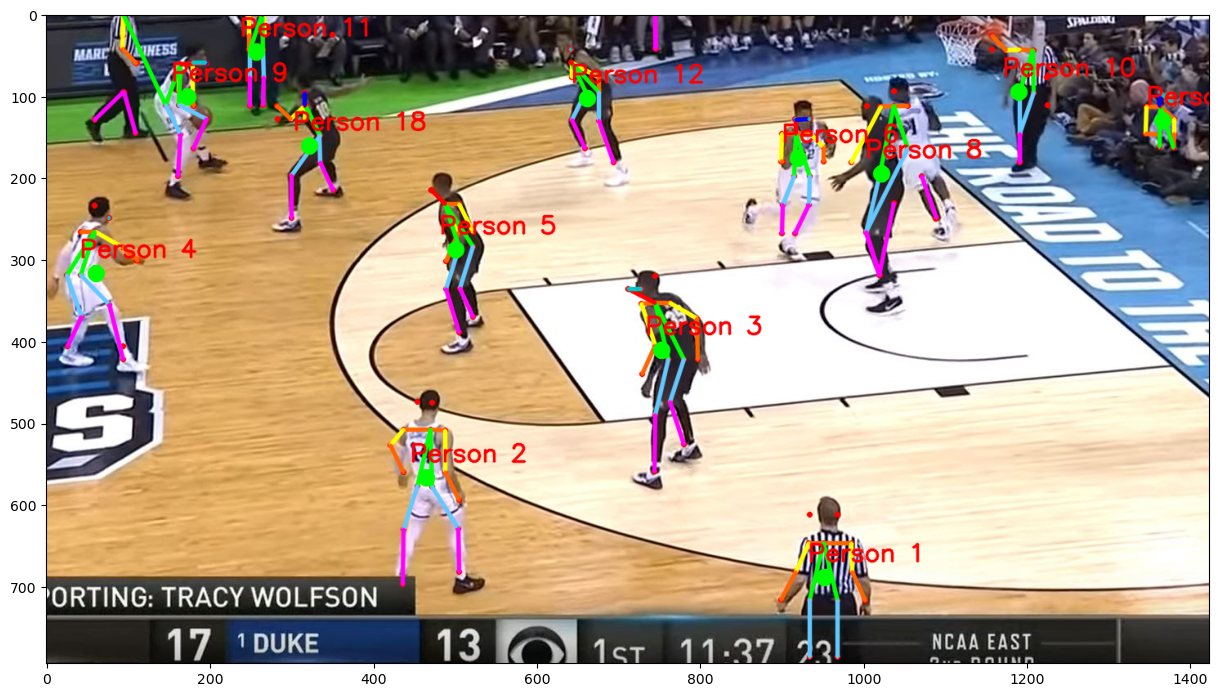

In [38]:

# Plotting the image with person IDs
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])


for i, coordinates in enumerate(person_coordinates):
    if i in indexes:
        x = int(coordinates[0])
        y = int(coordinates[1])

        # Draw a circle around the person's location
        cv2.circle(frameClone, (x, y), 10, (0, 255, 0), -1, cv2.LINE_AA)

        # Add the person's ID as text above the circle
        cv2.putText(frameClone, "Person {}".format(i+1), (x-20, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

# Display the image with person IDs
plt.imshow(frameClone[:,:,[2,1,0]])
plt.show()

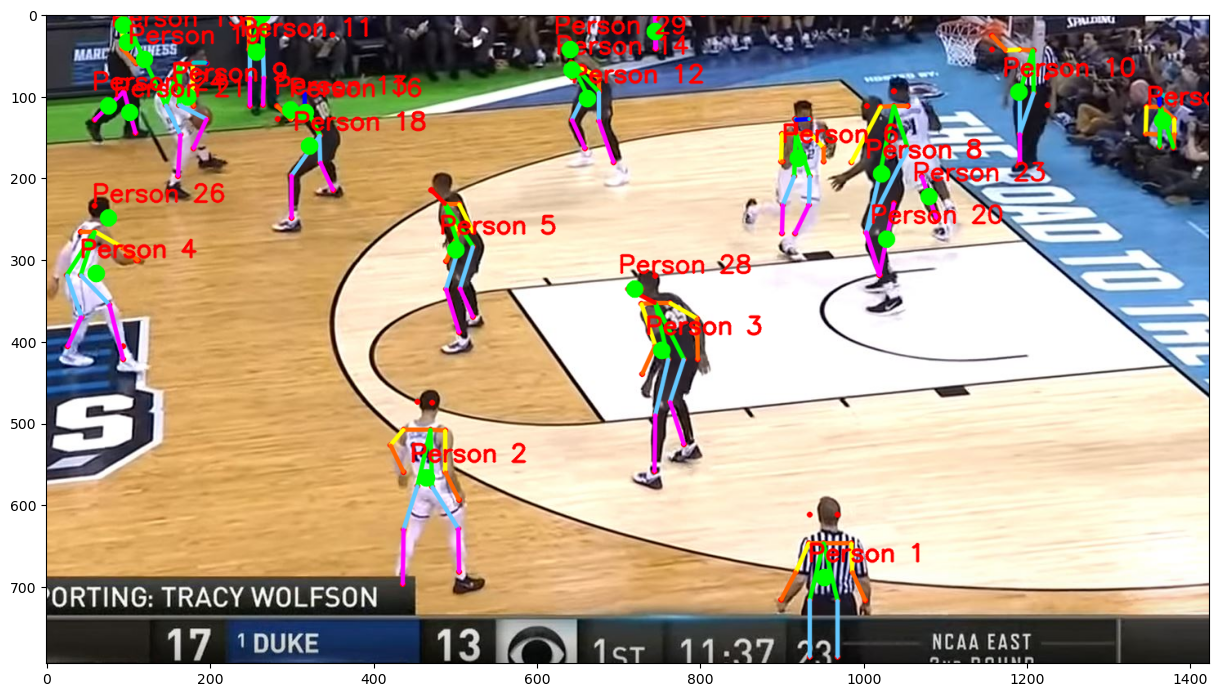

In [39]:
person_coordinates = []

for person in personwiseKeypoints:
    coordinates_sum = np.zeros(2)
    num_keypoints = 0

    for i in range(18):
        if person[i] != -1:
            coordinates_sum += keypoints_list[int(person[i]), :2]
            num_keypoints += 1

    if num_keypoints > 0:
        average_coordinates = coordinates_sum / num_keypoints
        person_coordinates.append(average_coordinates)

# Plotting the image with person IDs
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])


for i, coordinates in enumerate(person_coordinates):
    x = int(coordinates[0])
    y = int(coordinates[1])

    # Draw a circle around the person's location
    cv2.circle(frameClone, (x, y), 10, (0, 255, 0), -1, cv2.LINE_AA)

    # Add the person's ID as text above the circle
    cv2.putText(frameClone, "Person {}".format(i+1), (x-20, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

# Display the image with person IDs
plt.imshow(frameClone[:,:,[2,1,0]])
plt.show()

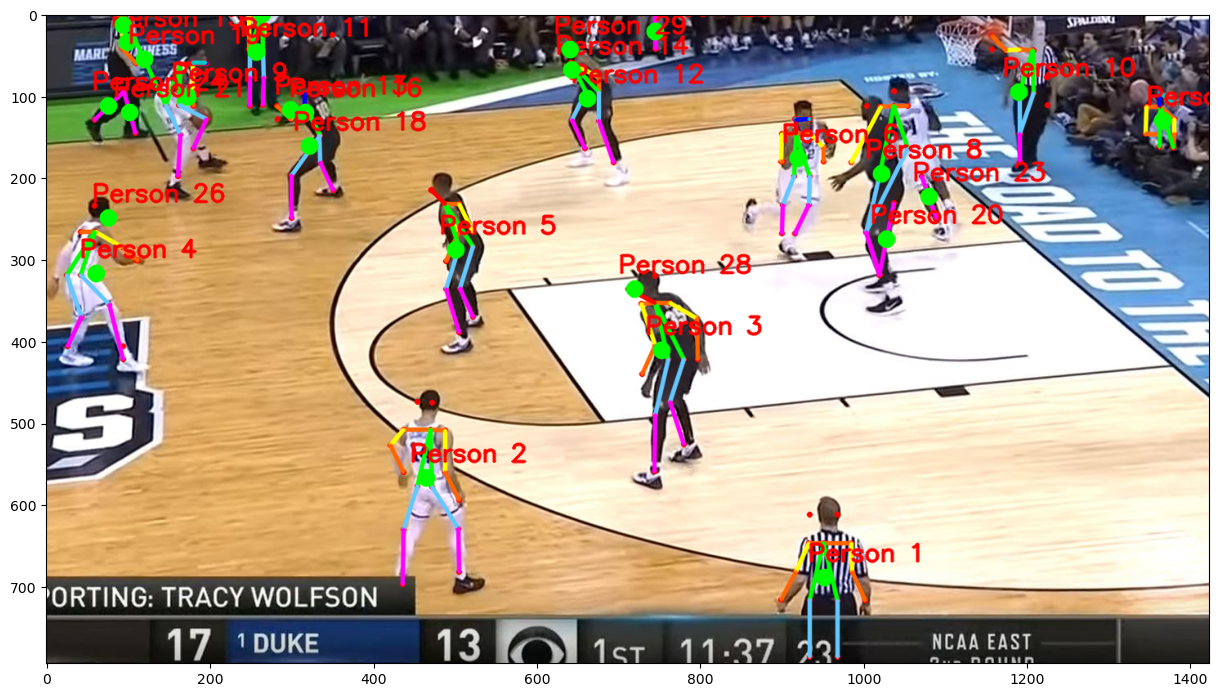

In [40]:
# Plotting the image with person IDs
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])


for i, coordinates in enumerate(person_coordinates):
    x = int(coordinates[0])
    y = int(coordinates[1])

    # Draw a circle around the person's location
    cv2.circle(frameClone, (x, y), 10, (0, 255, 0), -1, cv2.LINE_AA)

    # Add the person's ID as text above the circle
    cv2.putText(frameClone, "Person {}".format(i+1), (x-20, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

# Display the image with person IDs
plt.imshow(frameClone[:,:,[2,1,0]])
plt.show()

In [ ]:
def pose_estimation_video(filename):
    cap = cv2.VideoCapture(filename)
    # VideoWriter for saving the video
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter('videoOutput.mp4', fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))
    while cap.isOpened():
        (ret, frame) = cap.read()
        if ret == True:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            output, frame = run_inference(frame)
            frame = draw_keypoints(output, frame)
            frame = cv2.resize(frame, (int(cap.get(3)), int(cap.get(4))))
            out.write(frame)
            cv2_imshow(frame)
        else:
            break

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
pose_estimation_video('video.mp4')